# The QNLP Pipeline for Twitter Sentiment Analysis
## 1. Load the preprocessed data

In [1]:
import collections
import pickle
import warnings
warnings.filterwarnings("ignore")
import os
from random import shuffle
import random
from discopy.tensor import Tensor
from discopy import Word
from discopy.rigid import Functor
from discopy import grammar
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from jax import numpy as np
import numpy
from lambeq import AtomicType, IQPAnsatz, remove_cups, NumpyModel, spiders_reader
from lambeq import BobcatParser, TreeReader, cups_reader, DepCCGParser, TreeReaderMode
from lambeq import Dataset
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import TketModel
from lambeq import Rewriter
from pytket.extensions.qiskit import AerBackend
import seaborn as sns
import matplotlib.pyplot as plt
from pytket.circuit.display import render_circuit_jupyter

pd.set_option('display.width', 1000)
pd.options.display.max_colwidth=80
print(os.getcwd())
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
BATCH_SIZE = 50
EPOCHS = 200
SEED = 0

TRAIN_INDEX_RATIO = 0.08
VAL_INDEX_RATIO = TRAIN_INDEX_RATIO + 0.01
TEST_INDEX_RATIO = VAL_INDEX_RATIO + 0.01


assert TEST_INDEX_RATIO <= 1

def load_pickled_dict_to_df(filename):
    saved_dict = pickle.load(open(filename, 'rb'))
    df =  pd.DataFrame.from_dict(saved_dict)
    df =  df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    sentiment = []
    for i in df['target']:
        if i == "Positive":
            sentiment.append(1)
        else:
            sentiment.append(0)
    df["Sentiment"] = sentiment
    return df

cleaned_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data.pkl')
cleaned_lemmatized_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data_lematize.pkl')
cleaned_lemmatized_stemmed_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data_stem_lematize.pkl')

cleaned_qnlp = load_pickled_dict_to_df(cleaned_qnlp_filename)

cleaned_lemmatized_qnlp = load_pickled_dict_to_df(cleaned_lemmatized_qnlp_filename)

cleaned__lemmatized_stemmed_qnlp = load_pickled_dict_to_df(cleaned_lemmatized_stemmed_qnlp_filename)

/home/peiyongw/Desktop/Hackathon-QNLP


In [2]:
cleaned_qnlp.head(10)

,data,label,target,Sentiment
0,king you for your service,"[0, 1]",Positive,1
1,in discussing a typical si amulated internet phishing attack si amply over o...,"[0, 1]",Positive,1
2,oh man see fuck that,"[1, 0]",Negative,0
3,adjust ratings you clowns disrespected hi am going off,"[1, 0]",Negative,0
4,call of duty always got across a fuckin update,"[1, 0]",Negative,0
5,my face watches the riots on facebook,"[1, 0]",Negative,0
6,great servers while playing cl quals and pro league too i guess rubberbandin...,"[0, 1]",Positive,1
7,really enjoying the new vehicles on panzerstorm motor,"[0, 1]",Positive,1
8,did i hate league of legends,"[1, 0]",Negative,0
9,i suppose i can officially say i am addicted to,"[0, 1]",Positive,1


In [3]:
cleaned_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2578 entries, 0 to 2577
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       2578 non-null   object
 1   label      2578 non-null   object
 2   target     2578 non-null   object
 3   Sentiment  2578 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 80.7+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

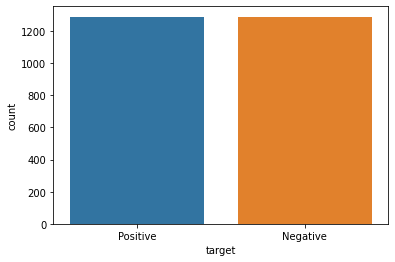

In [4]:
sns.countplot(x = "target", data = cleaned_qnlp)

In [5]:
cleaned_lemmatized_qnlp.head(10)

,data,label,target,Sentiment
0,thank you kevin peesker president,"[0, 1]",Positive,1
1,a sarahschachner i must ve been relistening to the anthemgame assassinscreed...,"[0, 1]",Positive,1
2,i am ded tired,"[1, 0]",Negative,0
3,adjust rating you clown disrespected hi am going off,"[1, 0]",Negative,0
4,i my love call of duty infinite warfare,"[0, 1]",Positive,1
5,and legend never die,"[0, 1]",Positive,1
6,this will also be trash,"[1, 0]",Negative,0
7,did not j j,"[1, 0]",Negative,0
8,did i hate league of legend,"[1, 0]",Negative,0
9,nice player model rhandlerr fix it pic twitter com,"[1, 0]",Negative,0


In [6]:
cleaned_lemmatized_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2578 entries, 0 to 2577
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       2578 non-null   object
 1   label      2578 non-null   object
 2   target     2578 non-null   object
 3   Sentiment  2578 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 80.7+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

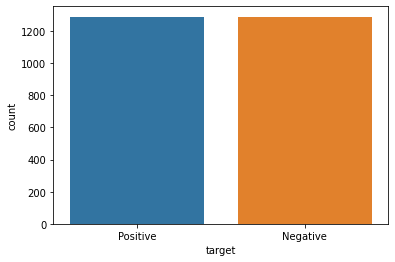

In [7]:
sns.countplot(x='target', data = cleaned_lemmatized_qnlp)

In [8]:
cleaned__lemmatized_stemmed_qnlp.head(10)

,data,label,target,Sentiment
0,king you for your servic,"[0, 1]",Positive,1
1,epic store close hahahah gta v kill it,"[0, 1]",Positive,1
2,fuck no that s back when everybodi didn t miss lmao,"[1, 0]",Negative,0
3,fifa wa so pain,"[1, 0]",Negative,0
4,call of duti alway got across a fuckin updat,"[1, 0]",Negative,0
5,remot work and an increas in cloud base data is spur cyber attack today see ...,"[0, 1]",Positive,1
6,i start be realli into play battlefield hardlin it s differ than most other ...,"[0, 1]",Positive,1
7,fuck sleep got ta watch the reveal trailer for cod black op cold war later a...,"[0, 1]",Positive,1
8,kill yourself and your playoverwatch s fault fuck you,"[1, 0]",Negative,0
9,nice player model rhandlerr fix it pic twitter com,"[1, 0]",Negative,0


In [9]:
cleaned__lemmatized_stemmed_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2578 entries, 0 to 2577
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       2578 non-null   object
 1   label      2578 non-null   object
 2   target     2578 non-null   object
 3   Sentiment  2578 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 80.7+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

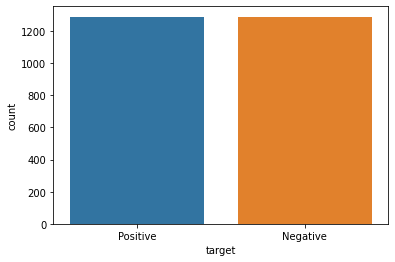

In [10]:
sns.countplot(x='target', data = cleaned__lemmatized_stemmed_qnlp)

## 2. Train QNLP Models for Different-Preprocessed Data
Since the limited parsing and training speed using on the CPU, we'll only use a fraction of our data.

In [12]:
# parser = BobcatParser(verbose='text')
# parser = DepCCGParser(root_cats=['S[dcl]'])
# parser = spiders_reader
parser = TreeReader(mode=TreeReaderMode.RULE_TYPE)
NUM_DATA = 2578

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
rewriter = Rewriter(['prepositional_phrase', 'determiner', 'auxiliary', 'connector', 
                         'coordination', 'object_rel_pronoun', 'subject_rel_pronoun',
                        'postadverb', 'preadverb'])
def rewrite(diagram):
    # diagram = rewriter(diagram)
    return remove_cups(diagram)

def create_diagrams_and_labels(total_df, NUM_DATA = 2578):
    total_text = total_df['data'].tolist()
    total_labels = total_df["Sentiment"].tolist()
    total_labels = [[t, 1-t] for t in total_labels] # [1, 0] for positive, [0, 1] for negative
    train_diagrams = parser.sentences2diagrams(total_text[:round(NUM_DATA*TRAIN_INDEX_RATIO)])
    train_labels = total_labels[:round(NUM_DATA*TRAIN_INDEX_RATIO)]
    dev_diagrams = parser.sentences2diagrams(total_text[round(NUM_DATA*TRAIN_INDEX_RATIO):round(NUM_DATA*VAL_INDEX_RATIO)])
    dev_labels = total_labels[round(NUM_DATA*TRAIN_INDEX_RATIO):round(NUM_DATA*VAL_INDEX_RATIO)]
    test_diagrams = parser.sentences2diagrams(total_text[round(NUM_DATA*VAL_INDEX_RATIO):round(NUM_DATA*TEST_INDEX_RATIO)])
    test_labels = total_labels[round(NUM_DATA*VAL_INDEX_RATIO):round(NUM_DATA*TEST_INDEX_RATIO)]
    
    return train_diagrams, train_labels, dev_diagrams, dev_labels, test_diagrams, test_labels

### 2.1 Data with both Lemmatization and Stemming
#### 2.1.1 Create diagrams

In [13]:
data = cleaned__lemmatized_stemmed_qnlp

In [14]:
raw_train_diagrams_1, train_labels_1, raw_dev_diagrams_1, dev_labels_1, raw_test_diagrams_1, test_labels_1 = create_diagrams_and_labels(data)
print(len(raw_train_diagrams_1))

206


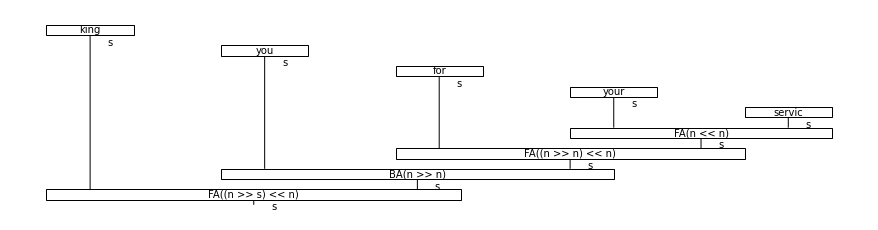

In [15]:
raw_train_diagrams_1[0].draw(figsize=(12,3))

#### 2.1.2 Simplify the diagrams

In [16]:
train_diagrams_1 = [rewrite(diagram) for diagram in raw_train_diagrams_1]
dev_diagrams_1 = [rewrite(diagram) for diagram in raw_dev_diagrams_1]
test_diagrams_1 = [rewrite(diagram) for diagram in raw_test_diagrams_1]

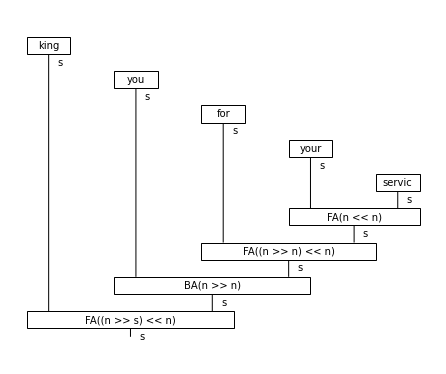

In [17]:
train_diagrams_1[0].draw(figsize=(6,5))

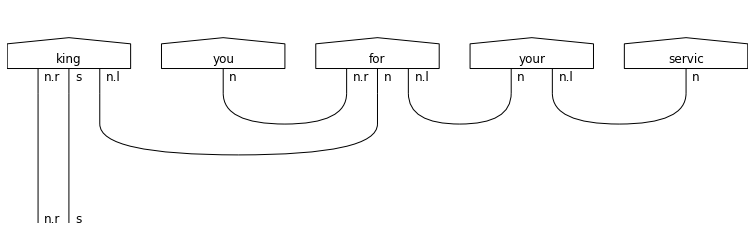

In [18]:
alternate_parser = BobcatParser(verbose='text')
dig_0 = alternate_parser.sentence2diagram(cleaned__lemmatized_stemmed_qnlp['data'].tolist()[0])
grammar.draw(dig_0, figsize=(14,3), fontsize=12)

#### 2.1.3 Create circuits

In [19]:
ansatz_1 = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1, AtomicType.NOUN_PHRASE:1, AtomicType.CONJUNCTION:1}, n_layers=1, n_single_qubit_params=3)
train_circuits_1 = [ansatz_1(diagram) for diagram in train_diagrams_1]
dev_circuits_1 =  [ansatz_1(diagram) for diagram in dev_diagrams_1]
test_circuits_1 = [ansatz_1(diagram) for diagram in test_diagrams_1]

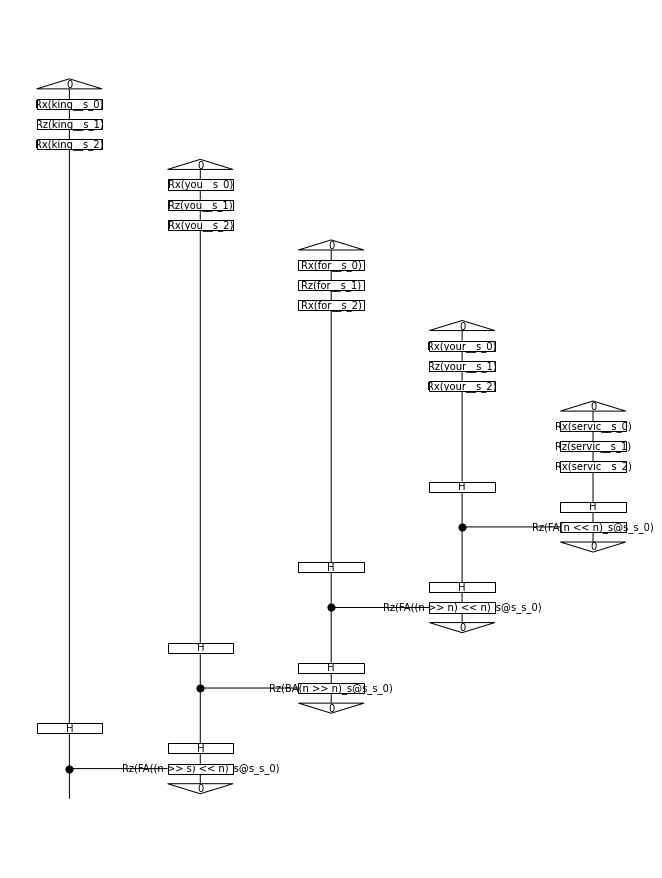

In [20]:
train_circuits_1[0].draw(figsize=(9, 12))

In [21]:
# train_circuits_1[0].draw(figsize=(9, 12))
render_circuit_jupyter(train_circuits_1[0].to_tk())

In [22]:
[(s, s.size) for s in train_circuits_1[0].free_symbols]

[(king__s_1, 1),
 (your__s_2, 1),
 (you__s_1, 1),
 (FA((n >> s) << n)_s@s_s_0, 1),
 (FA(n << n)_s@s_s_0, 1),
 (for__s_0, 1),
 (FA((n >> n) << n)_s@s_s_0, 1),
 (for__s_2, 1),
 (servic__s_1, 1),
 (servic__s_2, 1),
 (king__s_0, 1),
 (BA(n >> n)_s@s_s_0, 1),
 (servic__s_0, 1),
 (your__s_1, 1),
 (you__s_0, 1),
 (for__s_1, 1),
 (your__s_0, 1),
 (king__s_2, 1),
 (you__s_2, 1)]

#### 2.1.4 Parameterise

In [23]:
all_circuits_1 = train_circuits_1 + dev_circuits_1 + test_circuits_1
model_1 = NumpyModel.from_diagrams(all_circuits_1, use_jit=True)
# model_1 = TketModel.from_diagrams(all_circuits_1, backend_config=backend_config)

#### 2.1.5 Initialize trainer

In [24]:
trainer_1 = QuantumTrainer(
    model_1,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)
train_dataset_1 = Dataset(
            train_circuits_1,
            train_labels_1,
            batch_size=BATCH_SIZE)

val_dataset_1 = Dataset(dev_circuits_1, dev_labels_1, shuffle=False)

#### 2.1.6 Train

In [25]:
trainer_1.fit(train_dataset_1, val_dataset_1, logging_step=1)

Epoch 1:    train/loss: 0.7532   valid/loss: 0.8052   train/acc: 0.5243   valid/acc: 0.5000
Epoch 2:    train/loss: 0.7358   valid/loss: 0.8422   train/acc: 0.5437   valid/acc: 0.3846
Epoch 3:    train/loss: 0.7075   valid/loss: 0.8695   train/acc: 0.5291   valid/acc: 0.3077
Epoch 4:    train/loss: 0.7234   valid/loss: 0.8752   train/acc: 0.5728   valid/acc: 0.2692
Epoch 5:    train/loss: 0.6858   valid/loss: 0.8021   train/acc: 0.5631   valid/acc: 0.5000
Epoch 6:    train/loss: 0.7956   valid/loss: 0.7831   train/acc: 0.5194   valid/acc: 0.5385
Epoch 7:    train/loss: 0.7677   valid/loss: 0.7724   train/acc: 0.4854   valid/acc: 0.4615
Epoch 8:    train/loss: 0.6903   valid/loss: 0.7603   train/acc: 0.5874   valid/acc: 0.5000
Epoch 9:    train/loss: 0.6953   valid/loss: 0.7465   train/acc: 0.5583   valid/acc: 0.5000
Epoch 10:   train/loss: 0.6843   valid/loss: 0.7431   train/acc: 0.5874   valid/acc: 0.4615
Epoch 11:   train/loss: 0.6700   valid/loss: 0.7058   train/acc: 0.5777   valid/

#### 2.1.7 Show Results

Test accuracy: 0.0


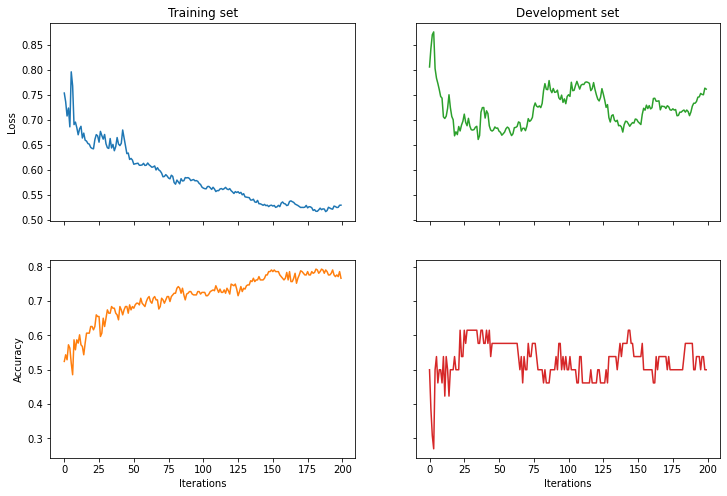

In [26]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(12, 8))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer_1.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer_1.train_results['acc'], color=next(colours))
ax_tr.plot(trainer_1.val_costs, color=next(colours))
ax_br.plot(trainer_1.val_results['acc'], color=next(colours))

test_acc_1 = acc(model_1(test_circuits_1), test_labels_1)
print('Test accuracy:', test_acc_1)

### 2.2 Data with only Lemmatization

In [27]:
data = cleaned_lemmatized_qnlp
raw_train_diagrams_1, train_labels_1, raw_dev_diagrams_1, dev_labels_1, raw_test_diagrams_1, test_labels_1 = create_diagrams_and_labels(data)
print(len(raw_train_diagrams_1))

206


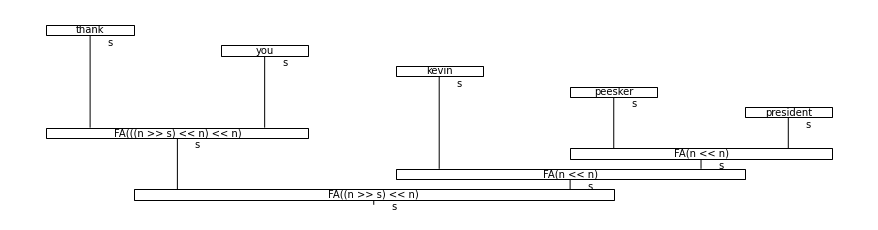

In [28]:
raw_train_diagrams_1[0].draw(figsize=(12,3))

In [29]:
train_diagrams_1 = [rewrite(diagram) for diagram in raw_train_diagrams_1]
dev_diagrams_1 = [rewrite(diagram) for diagram in raw_dev_diagrams_1]
test_diagrams_1 = [rewrite(diagram) for diagram in raw_test_diagrams_1]

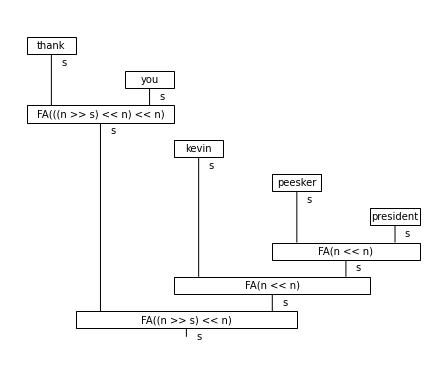

In [30]:
train_diagrams_1[0].draw(figsize=(6,5))

In [31]:
ansatz_1 = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1, AtomicType.NOUN_PHRASE:1, AtomicType.CONJUNCTION:1}, n_layers=1, n_single_qubit_params=3)
train_circuits_1 = [ansatz_1(diagram) for diagram in train_diagrams_1]
dev_circuits_1 =  [ansatz_1(diagram) for diagram in dev_diagrams_1]
test_circuits_1 = [ansatz_1(diagram) for diagram in test_diagrams_1]

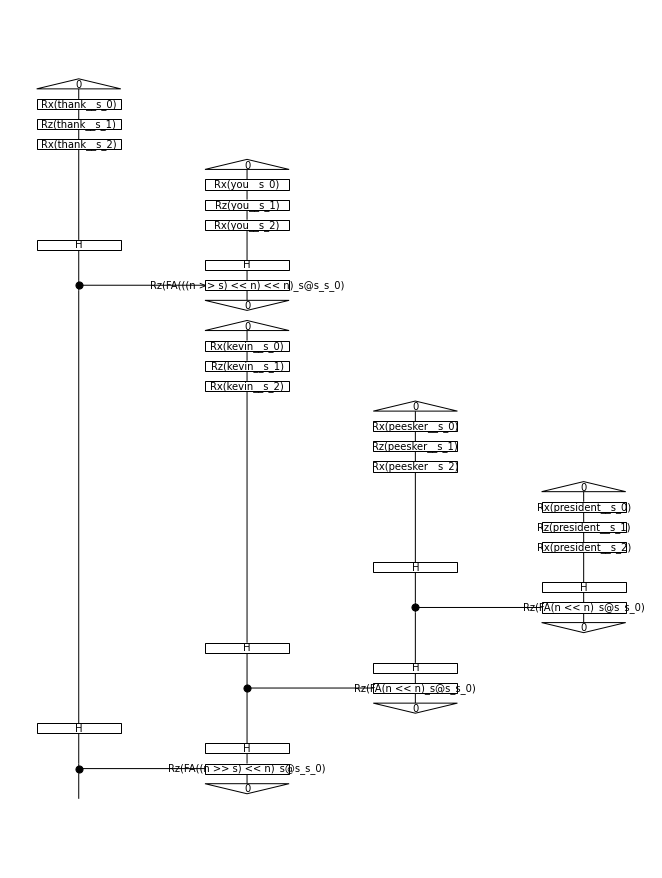

In [32]:
train_circuits_1[0].draw(figsize=(9, 12))

In [33]:
render_circuit_jupyter(train_circuits_1[0].to_tk())

In [34]:
all_circuits_1 = train_circuits_1 + dev_circuits_1 + test_circuits_1
model_1 = NumpyModel.from_diagrams(all_circuits_1, use_jit=True)

In [35]:
trainer_1 = QuantumTrainer(
    model_1,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)
train_dataset_1 = Dataset(
            train_circuits_1,
            train_labels_1,
            batch_size=BATCH_SIZE)

val_dataset_1 = Dataset(dev_circuits_1, dev_labels_1, shuffle=False)

In [36]:
trainer_1.fit(train_dataset_1, val_dataset_1, logging_step=1)

Epoch 1:    train/loss: 0.8216   valid/loss: 0.7457   train/acc: 0.4612   valid/acc: 0.5385
Epoch 2:    train/loss: 0.7483   valid/loss: 0.7948   train/acc: 0.5146   valid/acc: 0.5000
Epoch 3:    train/loss: 0.7834   valid/loss: 0.7746   train/acc: 0.5049   valid/acc: 0.5385
Epoch 4:    train/loss: 0.7482   valid/loss: 0.8217   train/acc: 0.5194   valid/acc: 0.3462
Epoch 5:    train/loss: 0.7250   valid/loss: 0.7766   train/acc: 0.4903   valid/acc: 0.3846
Epoch 6:    train/loss: 0.7429   valid/loss: 0.7852   train/acc: 0.4806   valid/acc: 0.4615
Epoch 7:    train/loss: 0.7223   valid/loss: 0.8606   train/acc: 0.5388   valid/acc: 0.4615
Epoch 8:    train/loss: 0.7234   valid/loss: 0.8189   train/acc: 0.5631   valid/acc: 0.4231
Epoch 9:    train/loss: 0.7164   valid/loss: 0.8395   train/acc: 0.5777   valid/acc: 0.4231
Epoch 10:   train/loss: 0.7301   valid/loss: 0.8428   train/acc: 0.5777   valid/acc: 0.2692
Epoch 11:   train/loss: 0.7183   valid/loss: 0.8634   train/acc: 0.5437   valid/

Test accuracy: 0.0


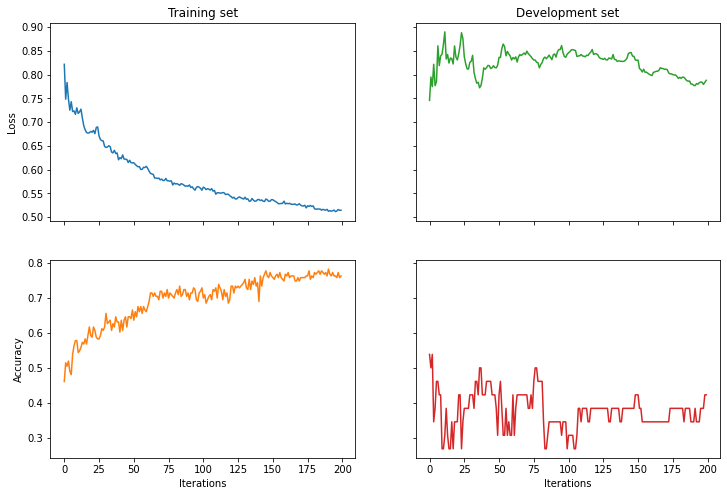

In [37]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(12, 8))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer_1.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer_1.train_results['acc'], color=next(colours))
ax_tr.plot(trainer_1.val_costs, color=next(colours))
ax_br.plot(trainer_1.val_results['acc'], color=next(colours))

test_acc_1 = acc(model_1(test_circuits_1), test_labels_1)
print('Test accuracy:', test_acc_1)

### 2.3 Data without Lemmatization or stemming

In [38]:
data = cleaned_qnlp
raw_train_diagrams_1, train_labels_1, raw_dev_diagrams_1, dev_labels_1, raw_test_diagrams_1, test_labels_1 = create_diagrams_and_labels(data)
print(len(raw_train_diagrams_1))

206


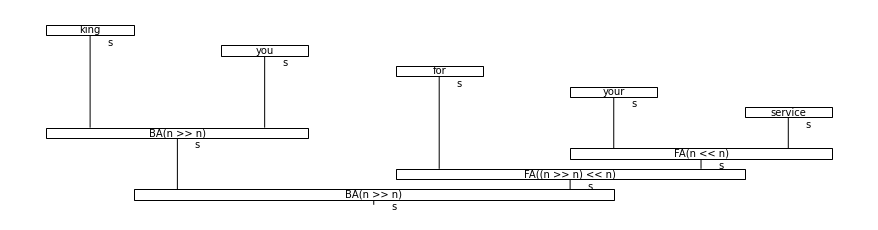

In [39]:
raw_train_diagrams_1[0].draw(figsize=(12,3))

In [40]:
train_diagrams_1 = [rewrite(diagram) for diagram in raw_train_diagrams_1]
dev_diagrams_1 = [rewrite(diagram) for diagram in raw_dev_diagrams_1]
test_diagrams_1 = [rewrite(diagram) for diagram in raw_test_diagrams_1]

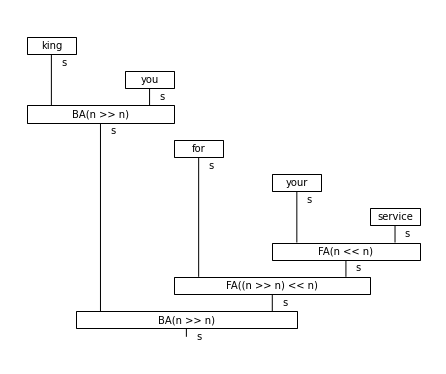

In [41]:
train_diagrams_1[0].draw(figsize=(6,5))

In [42]:
render_circuit_jupyter(train_circuits_1[0].to_tk())

In [43]:
all_circuits_1 = train_circuits_1 + dev_circuits_1 + test_circuits_1
model_1 = NumpyModel.from_diagrams(all_circuits_1, use_jit=True)

In [44]:
trainer_1 = QuantumTrainer(
    model_1,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)
train_dataset_1 = Dataset(
            train_circuits_1,
            train_labels_1,
            batch_size=BATCH_SIZE)

val_dataset_1 = Dataset(dev_circuits_1, dev_labels_1, shuffle=False)

In [45]:
trainer_1.fit(train_dataset_1, val_dataset_1, logging_step=1)

Epoch 1:    train/loss: 0.7969   valid/loss: 0.7646   train/acc: 0.4563   valid/acc: 0.5769
Epoch 2:    train/loss: 0.7202   valid/loss: 0.7331   train/acc: 0.5825   valid/acc: 0.5769
Epoch 3:    train/loss: 0.6982   valid/loss: 0.7437   train/acc: 0.5825   valid/acc: 0.5000
Epoch 4:    train/loss: 0.6757   valid/loss: 0.7260   train/acc: 0.5583   valid/acc: 0.5769
Epoch 5:    train/loss: 0.6724   valid/loss: 0.7137   train/acc: 0.5971   valid/acc: 0.6154
Epoch 6:    train/loss: 0.6803   valid/loss: 0.7293   train/acc: 0.5971   valid/acc: 0.4615
Epoch 7:    train/loss: 0.6880   valid/loss: 0.7350   train/acc: 0.5680   valid/acc: 0.3462
Epoch 8:    train/loss: 0.6966   valid/loss: 0.7806   train/acc: 0.5825   valid/acc: 0.4615
Epoch 9:    train/loss: 0.7018   valid/loss: 0.8442   train/acc: 0.5825   valid/acc: 0.3846
Epoch 10:   train/loss: 0.7140   valid/loss: 0.7501   train/acc: 0.5291   valid/acc: 0.5000
Epoch 11:   train/loss: 0.7000   valid/loss: 0.7615   train/acc: 0.6019   valid/

Test accuracy: 0.0


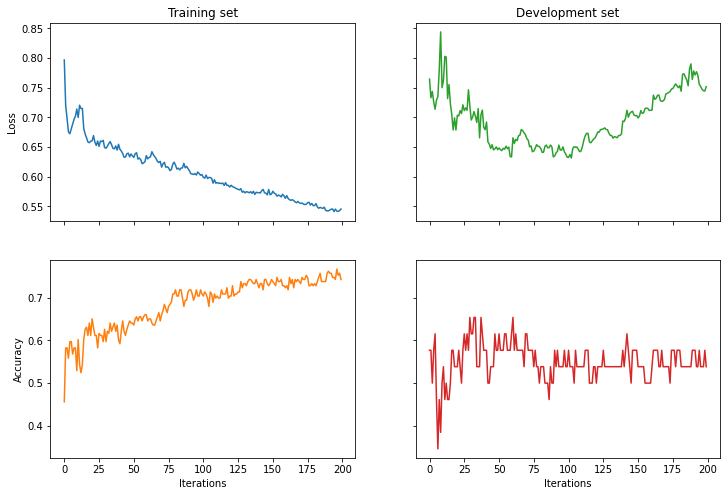

In [46]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(12, 8))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer_1.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer_1.train_results['acc'], color=next(colours))
ax_tr.plot(trainer_1.val_costs, color=next(colours))
ax_br.plot(trainer_1.val_results['acc'], color=next(colours))

test_acc_1 = acc(model_1(test_circuits_1), test_labels_1)
print('Test accuracy:', test_acc_1)